# Tutorial - Introduction to Lightwood's statistical analysis


As you might already know, Lightwood is designed to be a flexible machine learning (ML) library that is able to abstract and automate the entire ML pipeline. Crucially, it is also designed to be extended or modified very easily according to your needs, essentially offering the entire spectrum between fully automated AutoML and a lightweight wrapper for customized ML pipelines.

As such, we can identify several different customizable "phases" in the process. The relevant phase for this tutorial is the "statistical analysis" that is normally ran in two different places:

* To generate a Json AI object from some dataset and a problem definition
* To train a Lightwood predictor

In both cases, we generate a `StatisticalAnalyzer` object to store key facts about the data we are using, and refer to them afterwards.

## Objective

In this tutorial, we will take a look at the automatically generated statistical analysis for a sample dataset.

## Step 1: load the dataset and define the predictive task

The first thing we need is a dataset to analyze. Let's use the `adult` dataset (original source is [here](https://archive.ics.uci.edu/ml/datasets/adult)).

In [1]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/mindsdb/lightwood/stable/tests/data/adult.csv')
df.head()

,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
4,18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K


This dataset has information that belongs to a US census. Each row gives information about a person's status in terms of their educational background, marital status, and current occupation, among others.

We can see there are various columns with different data types, like integer (e.g. `age`) or categorical (e.g. `relationship`).

The predictive task proposed by the authors of the dataset is to estimate whether a person has an income equal or larger than 50k US dollars.

Lightwood provides an abstraction called `ProblemDefinition` to specify the target column of a dataset, along with other important parameters that you might want to define (for a complete list, check the documentation).

We will create a simple one:

In [2]:
from lightwood.api.high_level import ProblemDefinition

problem_definition = ProblemDefinition.from_dict({'target': 'income'})

Let's see how this object has been populated. `ProblemDefinition` is a Python `dataclass`, so it comes with some convenient tools to achieve this:

In [3]:
from dataclasses import fields

{field.name: getattr(problem_definition, field.name) for field in fields(ProblemDefinition)}

{'target': 'income',
 'pct_invalid': 2,
 'unbias_target': True,
 'seconds_per_mixer': None,
 'seconds_per_encoder': None,
 'time_aim': None,
 'target_weights': None,
 'positive_domain': False,
 'timeseries_settings': TimeseriesSettings(is_timeseries=False, order_by=None, window=None, group_by=None, use_previous_target=True, nr_predictions=None, historical_columns=None, target_type='', allow_incomplete_history=False),
 'anomaly_detection': True,
 'ignore_features': [],
 'fit_on_validation': True,
 'strict_mode': True,
 'seed_nr': 420}

Notice how, even though we only defined what the `target` was, there are a bunch of additional parameters that have been assigned a default value. That is fine for our purposes, but remember that you can set any of these according to your own predictive needs.

We also need to infer the type of each column. There is a method for this, `infer_types`, that we can use:

In [4]:
from lightwood.data import infer_types
from lightwood.api.types import TypeInformation

type_information = infer_types(df, problem_definition.pct_invalid)

{field.name for field in fields(TypeInformation)}  # show the fields this dataclass has

INFO:lightwood-15212:Analyzing a sample of 14037
INFO:lightwood-15212:from a total population of 48842, this is equivalent to 28.7% of your data.
INFO:lightwood-15212:Using 15 processes to deduct types.


{'additional_info', 'dtypes', 'identifiers'}

We can now check the inferred types:

In [5]:
type_information.dtypes

{'age': 'integer',
 'workclass': 'categorical',
 'fnlwgt': 'integer',
 'education': 'categorical',
 'educational-num': 'integer',
 'marital-status': 'categorical',
 'occupation': 'categorical',
 'relationship': 'categorical',
 'race': 'categorical',
 'gender': 'binary',
 'capital-gain': 'integer',
 'capital-loss': 'integer',
 'hours-per-week': 'integer',
 'native-country': 'categorical',
 'income': 'binary'}

Looks OK!

## Step 2: Run the statistical analysis

We now have all the necessary ingredients to run the statistical analysis. Normally, you would ask Lightwood for a Json AI object to be generated according to the dataset and the problem definition. Internally, Lightwood will then run the statistical analysis for the provided dataset, and store it for later usage.

Afterwards, you would make modifications to the Json AI as needed (for some examples, check out the other tutorials in `lightwood/examples/json_ai`), and finally generate a predictor object to learn and predict the task.

In this case though, we will call it directly:

In [6]:
from lightwood.api.types import StatisticalAnalysis  # the class where everything is stored
from lightwood.data import statistical_analysis      # generates an instance of the class

stan = statistical_analysis(df, 
                            type_information.dtypes, 
                            type_information.identifiers, 
                            problem_definition)

INFO:lightwood-15212:Starting statistical analysis
INFO:lightwood-15212:Finished statistical analysis


## Step 3: Peeking inside

Now that our analysis is complete, we can check what Lightwood thinks of this dataset:

In [7]:
{field.name for field in fields(StatisticalAnalysis)}  # show the fields this dataclass has

{'avg_words_per_sentence',
 'bias',
 'buckets',
 'df_std_dev',
 'distinct',
 'histograms',
 'missing',
 'nr_rows',
 'positive_domain',
 'target_class_distribution',
 'train_observed_classes'}

Some of these fields aren't really applicable nor useful for this dataset, so let's only check the ones that are. 

We can start with a very basic question: how many rows does the dataset have?

In [8]:
stan.nr_rows

48842

Here are some other insights produced in the analysis:

### Amount of missing information

Is there missing information in the dataset?

In [9]:
stan.missing

{'age': 0.0,
 'workclass': 0.0,
 'fnlwgt': 0.0,
 'education': 0.0,
 'educational-num': 0.0,
 'marital-status': 0.0,
 'occupation': 0.0,
 'relationship': 0.0,
 'race': 0.0,
 'gender': 0.0,
 'capital-gain': 0.0,
 'capital-loss': 0.0,
 'hours-per-week': 0.0,
 'native-country': 0.0,
 'income': 0.0}

Seemingly not!

### Buckets per column

For numerical colums, values are bucketized into discrete ranges.

Each categorical column gets a bucket per each observed class.

Let's check an example for one of each:

In [10]:
stan.buckets['educational-num']

[1, 2, 3, 4, 5, 6, 7, 8, 8, 9, 10, 11, 12, 13, 14, 15]

In [11]:
stan.buckets['relationship']

['Husband',
 'Not-in-family',
 'Own-child',
 'Unmarried',
 'Wife',
 'Other-relative']

### Bias per column

We can also check whether each column has buckets of data that exhibit some degree of bias:

In [12]:
for colname, col in stan.bias.items():
    print(f"'{colname}' entropy: {round(col['entropy'], 3)}")
    print(f"Biased buckets: {col['biased_buckets']}\n" if col['biased_buckets'] else '\n')

'age' entropy: 0.896


'workclass' entropy: 0.523


'fnlwgt' entropy: 0.656


'education' entropy: 0.733


'educational-num' entropy: 0.726


'marital-status' entropy: 0.654


'occupation' entropy: 0.902


'relationship' entropy: 0.834


'race' entropy: 0.342


'gender' entropy: 0.916


'capital-gain' entropy: 0.108
Biased buckets: [14000, 4000, 6000, 2000, 0]

'capital-loss' entropy: 0.076
Biased buckets: [1568, 1655, 1917, 1830, 0]

'hours-per-week' entropy: 0.588


'native-country' entropy: 0.173
Biased buckets: ['Philippines', '?', 'Mexico', 'United-States']

'income' entropy: 0.794




### Column histograms

Better yet, let's plot the histograms for each column:

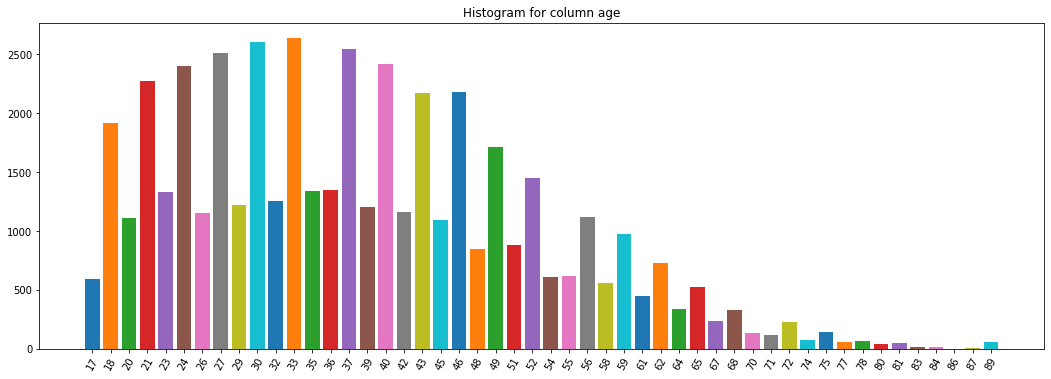

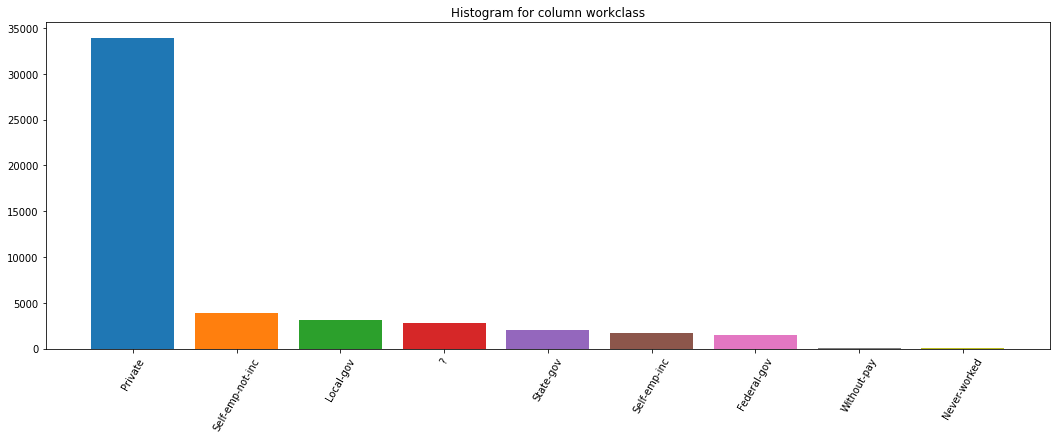

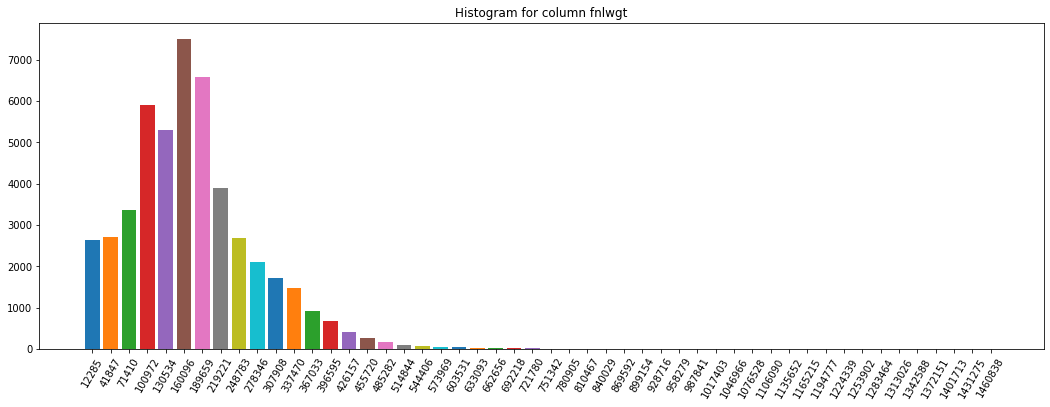

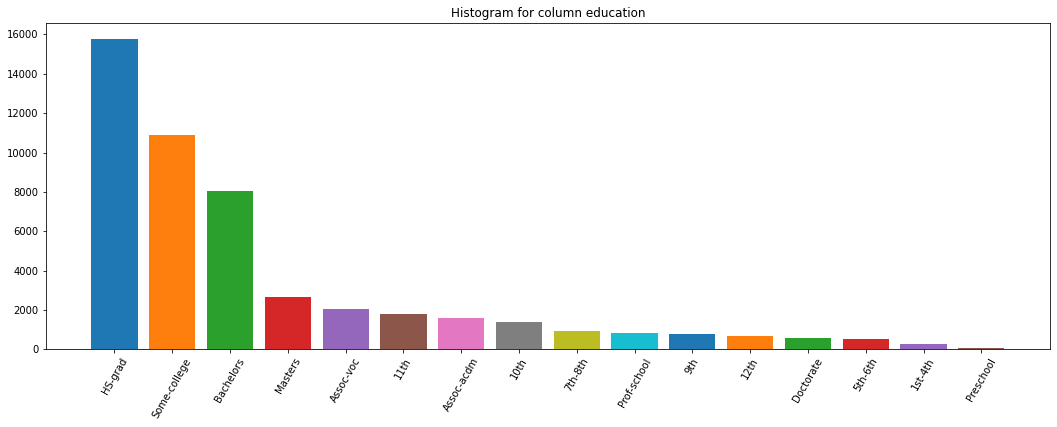

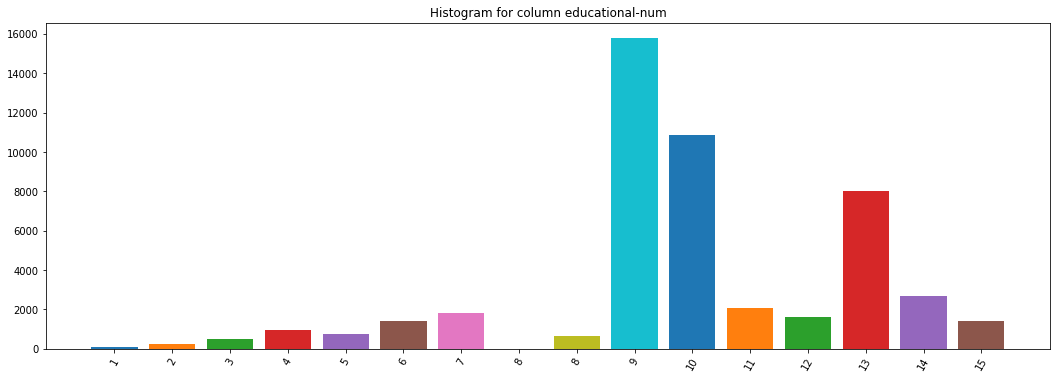

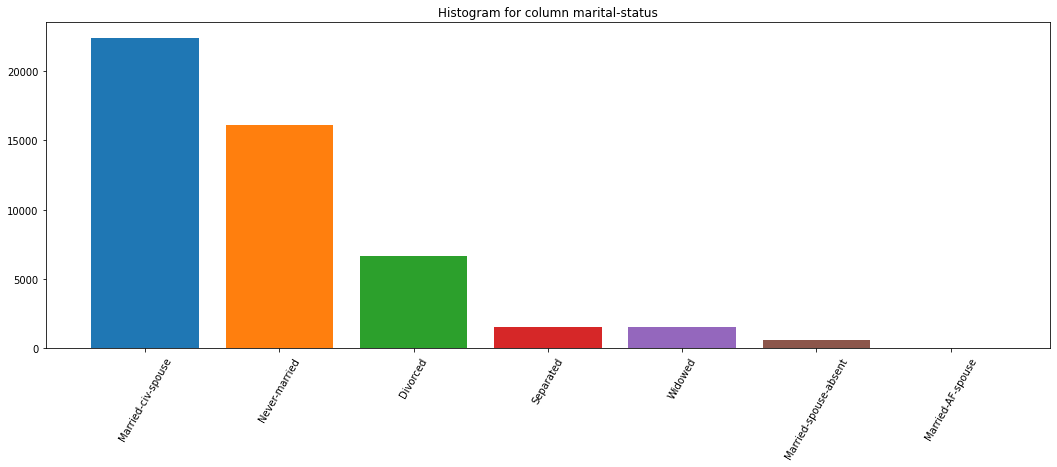

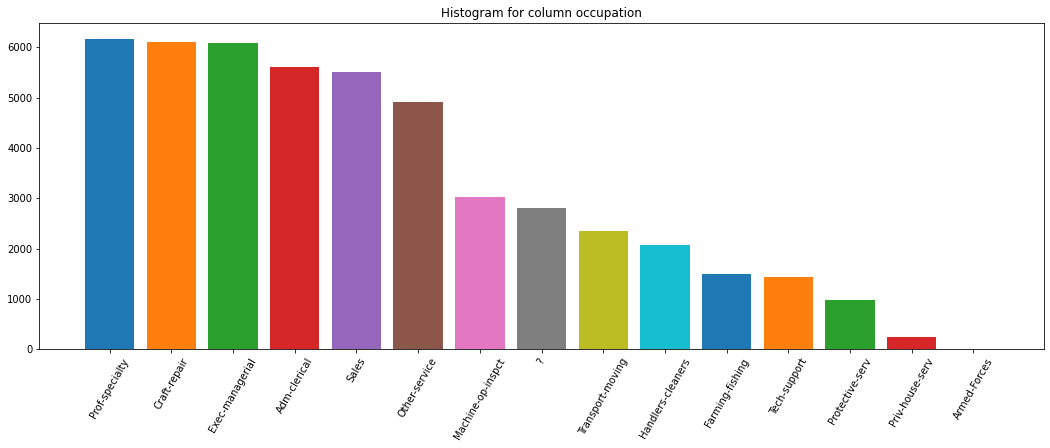

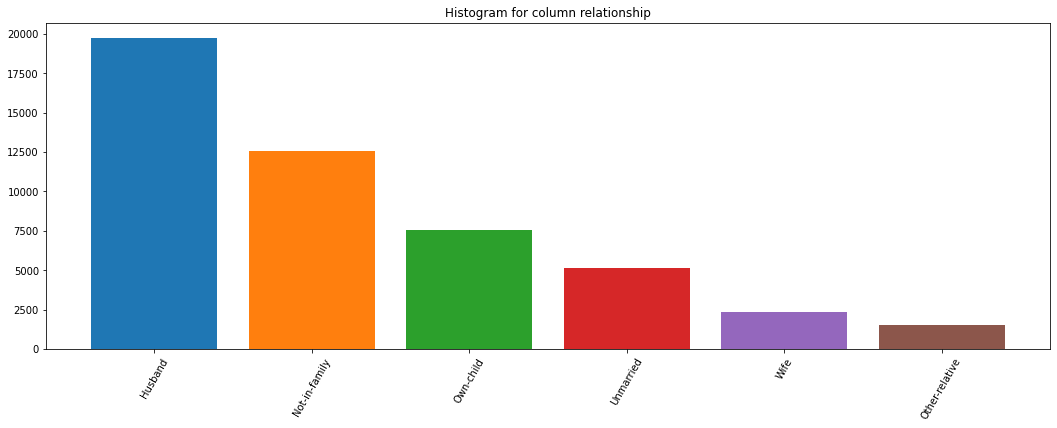

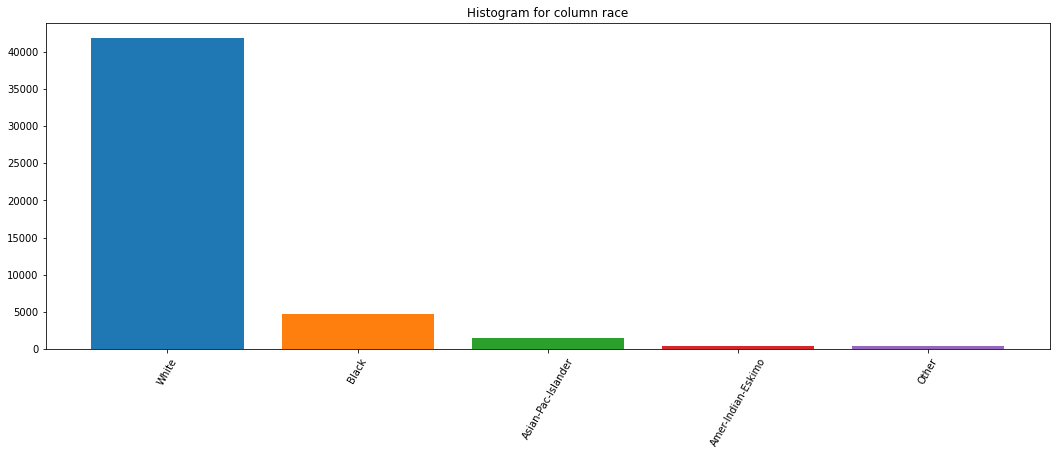

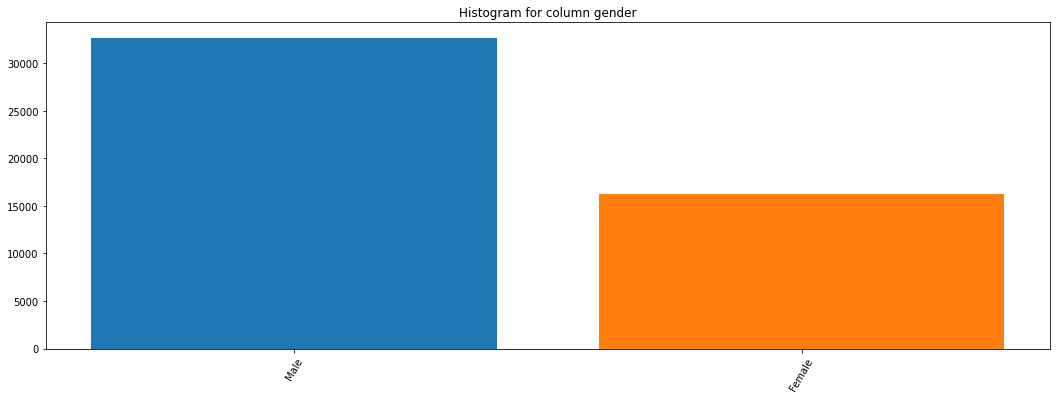

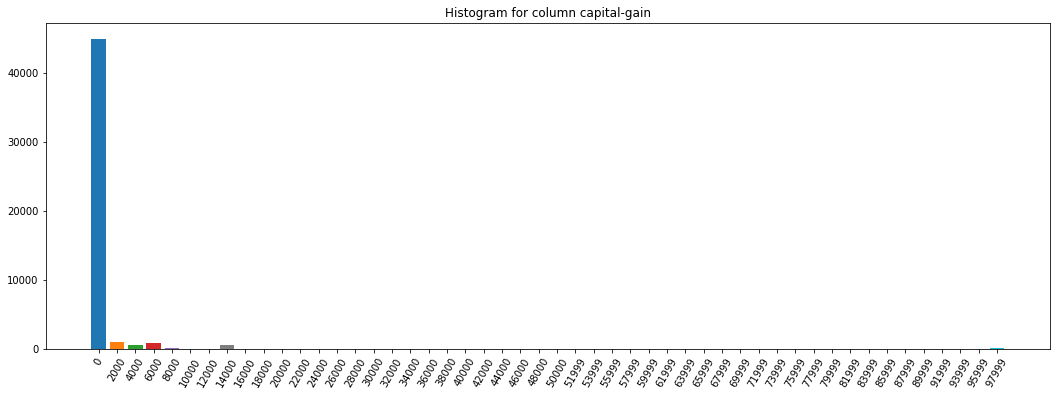

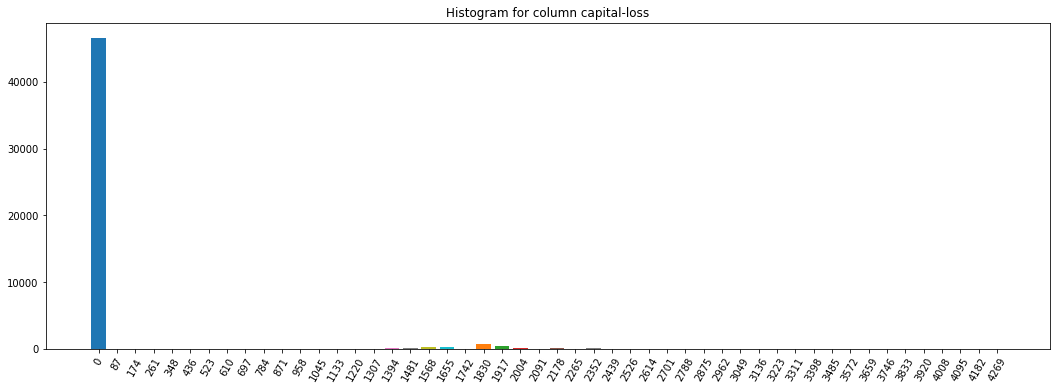

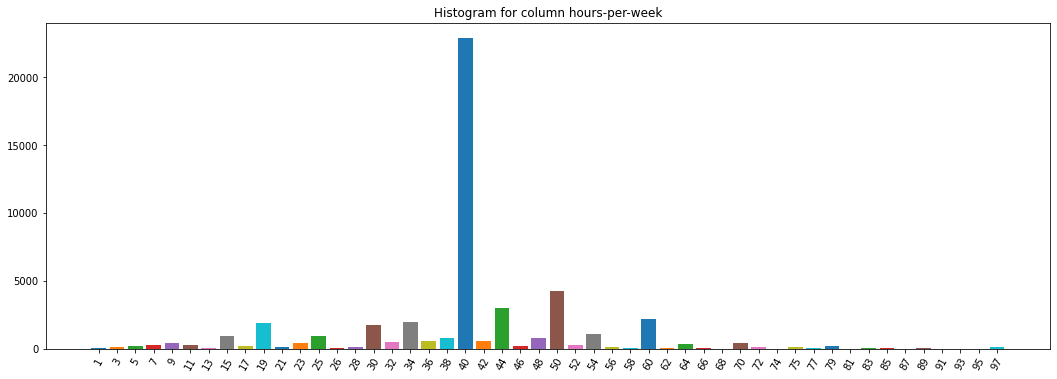

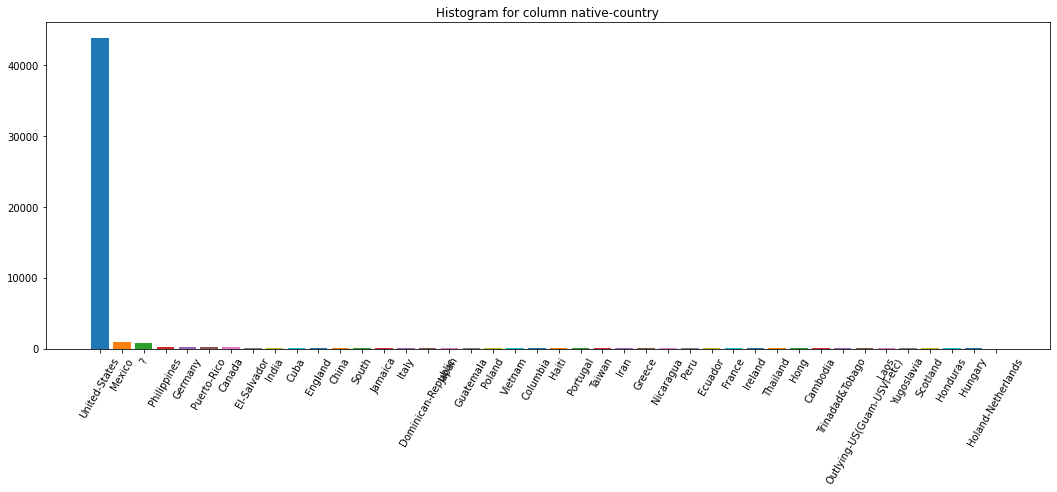

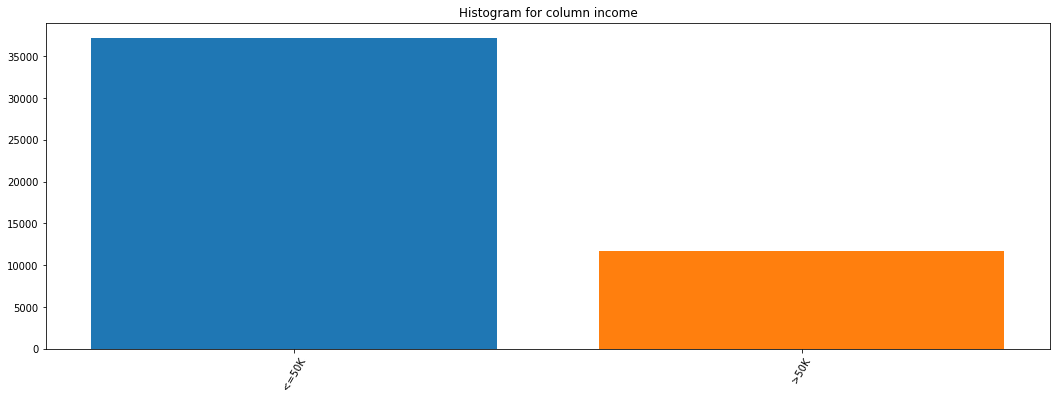

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# generate color map
cmap = plt.cm.tab10
colors = cmap(np.arange(len(df)) % cmap.N)

# barplot for each column
for colname, hist in stan.histograms.items():
    fig, ax = plt.subplots(figsize=(18, 6))
    
    ax.bar(np.arange(len(hist['x'])), hist['y'], color=colors)
    ax.set_xticks(np.arange(len(hist['x'])))
    ax.set_xticklabels(hist['x'], rotation=60)
    ax.set_title(f"Histogram for column {colname}")
    
    plt.show()

This way, it is fairly easy to understand how imbalanced the target distribution might be, along with a quick pass to search for outliers, for example.

# Final thoughts

Lightwood automatically tries to leverage all the information provided by a `StatisticalAnalysis` instance when generating a predictor for any given dataset and problem definition. Additionally, it is a valuable tool to explore the data as a user. 

Finally, be aware that you can access these insights when creating custom blocks (e.g. encoders, mixers, or analyzers) if you want, you just need to pass whatever is necessary as arguments to these blocks inside the Json AI object.
